# Case Study: Fraud detection using Autoencoders in Keras

## General Setup

In [1]:
# Import required packages
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

In [3]:
#set up graphic style (color scheme from xkcd.com)
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]

col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75)
sns.set_palette(sns.xkcd_palette(col_list))

## Description of the "Credit Card Fraud Detection" Dataset (Kaggle)

The "Credit Card Fraud Detection" dataset from Kaggle is a widely used benchmark for evaluating fraud detection systems. It contains transactions made by European cardholders over two days in September 2013. The dataset includes **284,807 transactions**, of which **492 are fraudulent**, resulting in a highly **imbalanced dataset** (only about 0.172% fraud cases).

**Key Features:**
- **Time**: The number of seconds elapsed between the first transaction in the dataset and the current transaction.
- **V1 to V28**: These are the result of a **PCA (Principal Component Analysis) transformation** applied to the original features for confidentiality reasons. The original features (like merchant name, location, etc.) are not included to protect sensitive information.
- **Amount**: The transaction amount, which can be useful for modeling.
- **Class**: The target variable. It takes the value **1** in case of fraud and **0** otherwise.

**Important Characteristics:**
- **Strong class imbalance**: Most machine learning models must be adapted or tuned (e.g., via resampling techniques or specialized loss functions) to handle the rare positive (fraud) cases.
- **PCA-transformed features**: No direct interpretation of the individual V1–V28 components is possible, but patterns can still be learned by models.
- **Real-world relevance**: Despite anonymization, the dataset reflects the challenges of detecting fraud in real transaction flows.

**Common Uses:**
- Testing anomaly detection algorithms.
- Experimenting with sampling strategies (e.g., SMOTE, undersampling).
- Benchmarking classification models, especially under imbalanced conditions.
- Studying precision-recall tradeoffs rather than focusing only on accuracy.

## Import and Check Data

In [4]:
df = pd.read_csv("C:/DATA/creditcard.csv")

In [5]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.shape

(284807, 31)

In [7]:
# No of null values in dataset
df.isnull().values.sum()

0

Indeed the data seems to be cleaned and loaded as we expect. Now we want to check if we have the expected number of normal and fraudulent rows of data. We will simply pull the "Class" column and count the number of normal (0) and fraud (1) rows.

In [8]:
pd.Series(df['Class']).value_counts(sort=True)

Class
0    284315
1       492
Name: count, dtype: int64

The counts are as expected (284,315 normal transactions and 492 fraud transactions). As is typical in fraud and anomaly detection in general, this is a very unbalanced dataset.

We will cut up the dataset into two data frames, one for normal transactions and the other for fraud

In [9]:
normal_df = df[df['Class']==0]
fraud_df  = df[df['Class']==1]

**Summary Statistics of the Transaction Amount Data**

In [10]:
normal_df.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [11]:
fraud_df.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Although the mean is a little higher in the fraud transactions, it is certainly within a standard deviation and so is unlikely to be easy to discriminate in a highly precise manner between the classes with pure statistical methods.

## Visual Exploration of the Transaction Amount Data

In anomaly detection datasets it is common to have the areas of interest "washed out" by abundant data. In this dataset, a lot of low-value transactions that will be generally uninteresting (buying cups of coffee, lunches, etc). This abundant data is likely to wash out the rest of the data, so looking at transactions which are $200+

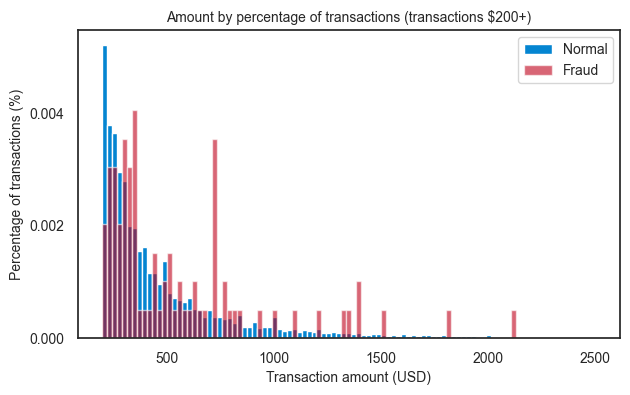

In [12]:
# Define bins for the histogram:
# Create 100 evenly spaced values between $200 and $2500.
# These bins will define the ranges for transaction amounts in the histograms.
bins = np.linspace(200, 2500, 100)

# Set the figure size for the plot
plt.figure(figsize=(7, 4))

# Plot histogram for normal (non-fraudulent) transactions:
# - 'Amount' column from the normal transactions dataframe (normal_df).
# - Use the previously defined bins.
# - 'alpha=1' means fully opaque.
# - 'density=True' normalizes the histogram so the total area equals 1 (useful for comparing distributions).
# - 'label' sets the label that will appear in the legend.
plt.hist(normal_df.Amount, bins, alpha=1, density=True, label='Normal')

# Plot histogram for fraudulent transactions:
# - 'Amount' column from the fraud transactions dataframe (fraud_df).
# - Same bins as above for direct comparison.
# - 'alpha=0.6' makes this plot slightly transparent (easier to compare overlapping areas).
# - 'density=True' again normalizes the histogram.
# - 'label' identifies the curve as representing fraud cases.
plt.hist(fraud_df.Amount, bins, alpha=0.6, density=True, label='Fraud')

# Add a legend in the upper right corner to differentiate 'Normal' and 'Fraud' plots
plt.legend(loc='upper right', fontsize=10)
# Set the title of the plot
plt.title("Amount by percentage of transactions (transactions \$200+)", fontsize=10)
# Set the x-axis label
plt.xlabel("Transaction amount (USD)", fontsize=10)
# Set the y-axis label
plt.ylabel("Percentage of transactions (%)", fontsize=10)
plt.xticks(fontsize=10)   # X-axis ticks font size
plt.yticks(fontsize=10)   # Y-axis ticks font size
# Display the plot
plt.show()

Since the fraud cases are relatively few in number compared to bin size, we see the data looks predictably more variable. In the long tail, especially, we are likely observing only a single fraud transaction. ***It would be hard to differentiate fraud from normal transactions by transaction amount alone***.

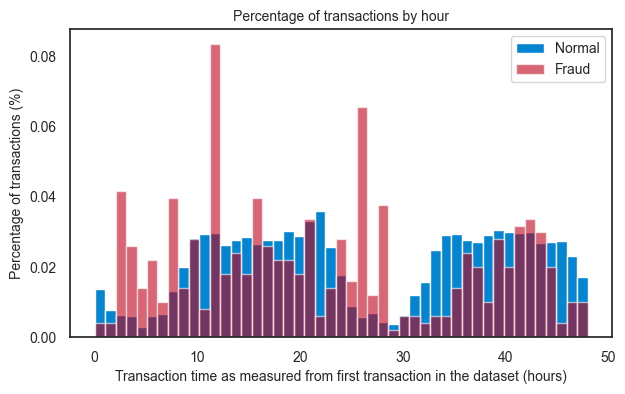

In [13]:
bins = np.linspace(0, 48, 48) #48 hours
plt.figure(figsize=(7, 4))
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, density=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right', fontsize=10)
plt.title("Percentage of transactions by hour", fontsize=10)
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)", fontsize=10)
plt.ylabel("Percentage of transactions (%)", fontsize=10);
# plt.hist((df.Time/(60*60)),bins)
plt.xticks(fontsize=10)   # X-axis ticks font size
plt.yticks(fontsize=10)   # Y-axis ticks font size

plt.show()

Hour "zero" corresponds to the hour the first transaction happened and not necessarily 12-1am. Given the heavy decrease in normal transactions from hours 1 to 8 and again roughly at hours 24 to 32, we can assume those time correspond to nighttime for this dataset. If this is true, fraud tends to occur at higher rates during the night. Statistical tests could be used to give evidence for this fact, but are not in the scope of this article. Again, however, ***the potential time offset between normal and fraud transactions is not enough to make a simple, precise classifier***.

## Using Autoencoder

### Normalize and Scale Data¶

Both time and amount have very different magnitudes, which will likely result in the large magnitude value "washing out" the small magnitude value. It is therefore common to scale the data to similar magnitudes. As most of the data (other than 'time' and 'amount') result from the product of a PCA analysis. The PCA done on the dataset transformed it into standard-normal form. We will do the same to the 'time' and 'amount' columns.

In [14]:
df_norm = df.copy()
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
# or array.reshape(1, -1) if it contains a single sample.
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

### Dividing Training and Test Set

Now we split the data into training and testing sets according to the percentage and with a random seed we wrote at the beginning of the code.

In [15]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0]       # where normal transactions
train_x = train_x.drop(['Class'], axis=1)   # drop the class column


test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray

## Creating The Model

### Autoencoder Layer Structure and Parameters

Autoencoder has symmetric encoding and decoding layers that are "dense". We are reducing the input into some form of simplified encoding and then expanding it again. The input and output dimension is the feature space (e.g. 30 columns), so the encoding layer should be smaller by an amount that expect to represent some feature. In this case, we are encoding 30 columns into 14 dimensions so we are expecting high-level features to be represented by roughly two columns (30/14 = 2.1). Of those high-level features, we are expecting them to map to roughly seven hidden/latent features in the data.

Additionally, the epochs, batch size, learning rate, learning policy, and activation functions were all set to values empirically good values.

In [16]:
nb_epoch      = 250
batch_size    = 128
input_dim     = train_x.shape[1] #num of columns, 30
encoding_dim  = 18
hidden_dim1   = 10 #int(encoding_dim / 2) #i.e. 7
hidden_dim2   = 6
learning_rate = 1e-7

In [17]:
# This returns a tensor
input_layer = Input(shape=(input_dim, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument, 

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)
decoder = Dense(hidden_dim2, activation='elu')(encoder)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 18)                  │             558 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             190 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │              42 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,256 (4.91 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

In [18]:
# Saving the model
cp = ModelCheckpoint(filepath="autoencoder_fraud.keras",
                     save_best_only=True,
                     verbose=0)

In [19]:
# TensorBoard basic visualizations.
# This callback writes a log for TensorBoard, 
# which allows you to visualize dynamic graphs of your training and test metrics
tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)

In [25]:
# Starts training
# autoencoder: same training(x) and target data(y)
# validation_data: tuple (x_val, y_val) on which 
# to evaluate the loss and any model metrics at the end of each epoch.

# History.history attribute is a record of training loss values 
# and metrics values at successive epochs.
history = autoencoder.fit(x=train_x, y=train_x,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_x, test_x),
                          verbose=1,
                          callbacks=[cp, tb]).history

Epoch 1/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6647 - loss: 0.5296 - val_accuracy: 0.6667 - val_loss: 0.5562
Epoch 2/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6670 - loss: 0.5264 - val_accuracy: 0.6633 - val_loss: 0.5579
Epoch 3/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6649 - loss: 0.5301 - val_accuracy: 0.6688 - val_loss: 0.5558
Epoch 4/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6651 - loss: 0.5313 - val_accuracy: 0.6627 - val_loss: 0.5551
Epoch 5/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6650 - loss: 0.5237 - val_accuracy: 0.6664 - val_loss: 0.5558
Epoch 6/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6652 - loss: 0.5182 - val_accuracy: 0.6650 - val_loss: 0.5551
Epoch 7/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6659 - loss: 0.5174 - val_accuracy: 0.6572 - val_loss: 0.5568
Epoch 8/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6650 - loss: 

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6651 - loss: 0.5125 - val_accuracy: 0.6657 - val_loss: 0.5461
Epoch 100/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6670 - loss: 0.5201 - val_accuracy: 0.6617 - val_loss: 0.5481
Epoch 101/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6655 - loss: 0.4994 - val_accuracy: 0.6637 - val_loss: 0.5455
Epoch 102/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6663 - loss: 0.5116 - val_accuracy: 0.6637 - val_loss: 0.5454
Epoch 103/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6647 - loss: 0.5128 - val_accuracy: 0.6617 - val_loss: 0.5459
Epoch 104/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6646 - loss: 0.5035 - val_accuracy: 0.6689 - val_loss: 0.5456
Epoch 105/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6659 - loss: 0.5097 - val_accuracy: 0.6663 - val_loss: 0.5458
Epoch 106/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6655 - los

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6664 - loss: 0.5089 - val_accuracy: 0.6608 - val_loss: 0.5433
Epoch 198/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6650 - loss: 0.5159 - val_accuracy: 0.6619 - val_loss: 0.5432
Epoch 199/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6669 - loss: 0.5168 - val_accuracy: 0.6614 - val_loss: 0.5439
Epoch 200/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6680 - loss: 0.5065 - val_accuracy: 0.6646 - val_loss: 0.5455
Epoch 201/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6686 - loss: 0.5040 - val_accuracy: 0.6569 - val_loss: 0.5433
Epoch 202/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6658 - loss: 0.5154 - val_accuracy: 0.6590 - val_loss: 0.5477
Epoch 203/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6648 - loss: 0.5176 - val_accuracy: 0.6581 - val_loss: 0.5451
Epoch 204/250
1778/1778 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6656 - loss

In [26]:
import pickle

# Save the history dictionary
with open("autoencoder_history.pkl", "wb") as f:
    pickle.dump(history, f)

In [20]:
with open("autoencoder_history.pkl", "rb") as f:
    history = pickle.load(f) 

In [21]:
autoencoder = load_model('autoencoder_fraud.keras')

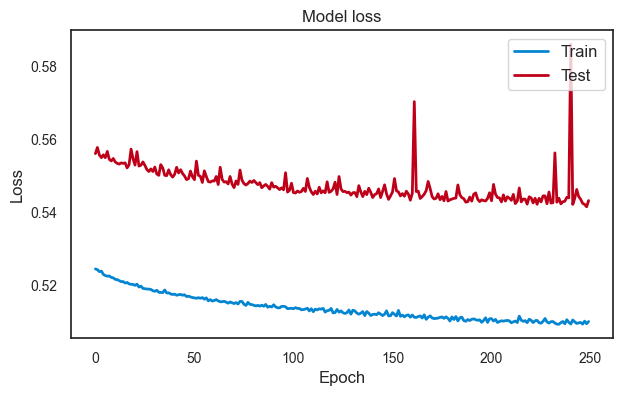

In [22]:
plt.figure(figsize=(7, 4))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right', fontsize=12)
plt.title('Model loss', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
#plt.ylim(ymin=0.70,ymax=1)
plt.xticks(fontsize=10)   # X-axis ticks font size
plt.yticks(fontsize=10)   # Y-axis ticks font size
plt.show()

In [24]:
# Step 1: Use the trained autoencoder to predict (reconstruct) the test set
# This passes the input 'test_x' through the full autoencoder (encoder + decoder)
# and produces a reconstructed version of each input sample
test_x_predictions = autoencoder.predict(test_x)

# Step 2: Calculate the reconstruction error (Mean Squared Error) for each sample
# - Subtract the reconstructed inputs from the original inputs
# - Square the difference element-wise
# - Compute the mean error across all features (axis=1 means row-wise for each sample)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)

# Step 3: Create a DataFrame to collect reconstruction errors and the true labels
# - 'Reconstruction_error' column stores the computed MSE for each sample
# - 'True_class' column stores the true label for each sample (0 = normal, 1 = fraud)
error_df = pd.DataFrame({
    'Reconstruction_error': mse,
    'True_class': test_y
})

# Step 4: Display descriptive statistics of the reconstruction errors and labels
# - This includes count, mean, standard deviation, min, max, and percentiles
# - Helps to understand the overall distribution of errors for both normal and fraudulent transactions
error_df.describe()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.541478,0.002019
std,2.937039,0.044887
min,0.026953,0.000000
25%,0.147886,0.000000
50%,0.235826,0.000000
75%,0.415485,0.000000
max,184.862731,1.000000


**PRECISION**

> Precision answers the question:
> **"Of all the transactions the model predicted as fraud, how many were actually fraud?"**

Formula:

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

* **TP (True Positives)** = Fraud correctly detected as fraud
* **FP (False Positives)** = Normal transactions incorrectly flagged as fraud

In this context:

* High precision → Most of the flagged frauds **are truly fraud**.
* Low precision → Many **false alarms** (normal transactions wrongly flagged).

---

**RECALL**

> Recall answers the question:
> **"Of all the actual frauds, how many did the model catch?"**

Formula:

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

* **FN (False Negatives)** = Fraud transactions **missed** (reconstructed with low error and classified as normal)

In this context:

* High recall → The model **catches most frauds**.
* Low recall → The model **misses many fraudulent transactions**.

---

**Summary Table**

| Metric        | What It Measures               | Why It Matters in Fraud Detection                |
| ------------- | ------------------------------ | ------------------------------------------------ |
| **Precision** | Correctness of fraud alarms    | Avoids wasting time/resources on false positives |
| **Recall**    | Coverage of actual fraud cases | Ensures most frauds are not missed               |

Most normal transactions are reconstructed with low error (around 0.2–0.4).
- A few transactions show very large reconstruction errors (up to ~188), likely corresponding to fraudulent activities.
- This indicates that the autoencoder learned the structure of normal transactions well and struggles with outliers (fraud cases), which ***is exactly the intended behavior***.


**To turn these reconstruction errors into actual predictions:**

We would choose a threshold: if Reconstruction_error > threshold, classify as fraud.

Threshold choice affects precision and recall — For this reason we usually plot the Precision-Recall curve or ROC curve to tune it properly.

Great question. Selecting a **good threshold** on the **reconstruction error** is a *critical step* in turning your autoencoder from a reconstruction model into an effective **fraud detector**.

---

## 🎯 **Goal of the Threshold**

We compute reconstruction error for each transaction. A **high error** means the transaction doesn’t fit the pattern of “normal” data.

You must choose a **threshold** `T` such that:

* `Reconstruction error > T` → classify as **fraud (1)**
* `Reconstruction error ≤ T` → classify as **normal (0)**

**Unfortunately This Is Not Trivial at all**

* **Low threshold** → catch all frauds (high recall) but many false positives (low precision).
* **High threshold** → fewer false positives (high precision) but more missed frauds (low recall).

So, the choice depends on what you value more:

* In finance, **false negatives (missed fraud)** are often worse than **false positives (false alarms)**.
* But **too many false alarms** can overwhelm manual reviewers or users.

### ROC Curve Check

Receiver operating characteristic curves are an expected output of most binary classifiers. Since we have an imbalanced data set they are somewhat less useful. Why? Because you can generate a pretty good-looking curve by just simply guessing everything is the normal case because there are so proportionally few cases of fraud.

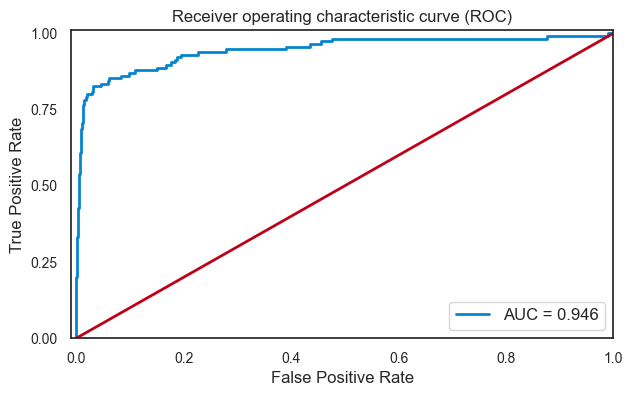

In [25]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize=(7, 4))
plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=2)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right', fontsize=12)
plt.title('Receiver operating characteristic curve (ROC)', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.xticks(fontsize=10)   # X-axis ticks font size
plt.yticks(fontsize=10)   # Y-axis ticks font size

plt.show()

In [26]:
# Compute the "distance" from perfect point (0,1)
j_scores = true_pos_rate - false_pos_rate
j_best_index = np.argmax(j_scores)
optimal_threshold_roc = thresholds[j_best_index]

print(f"Best threshold by Youden's J statistic: {optimal_threshold_roc}")

Best threshold by Youden's J statistic: 1.6640657413286912


### Recall vs. Precision Thresholding

Now let's look at recall vs. precision to see the trade-off between the two.

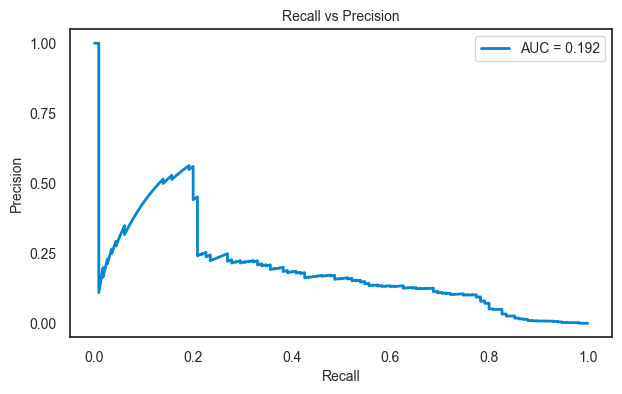

In [27]:
# calculates precision/recall using reconstruction error as the decision function
# returns: 
# precision_rt: Precision values such that element i is the precision of predictions with 
#               score >= thresholds[i] and the last element is 1.
# recall_rt: Decreasing recall values such that element i is the recall of predictions with 
#           score >= thresholds[i] and the last element is 0.
# threshold_rt = Increasing thresholds on the decision function used to compute
#                precision and recall.
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

pr_auc = auc(recall_rt, precision_rt,)

plt.figure(figsize=(7, 4))
plt.plot(recall_rt, precision_rt, linewidth=2, label='AUC = %0.3f'% pr_auc)
plt.legend(loc='upper right', fontsize=10)
plt.title('Recall vs Precision', fontsize=10)
plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize=10)
plt.xticks(fontsize=10)   # X-axis ticks font size
plt.yticks(fontsize=10)   # Y-axis ticks font size

plt.show()

Precision and recall are the eternal tradeoff in data science, so at some point you have to draw an arbitrary line, or a threshold. Where this line will be drawn is essentially a business decision. In this case, you are trading off the cost between missing a fraudulent transaction and the cost of falsely flagging the transaction as a fraudulent even when it is not.

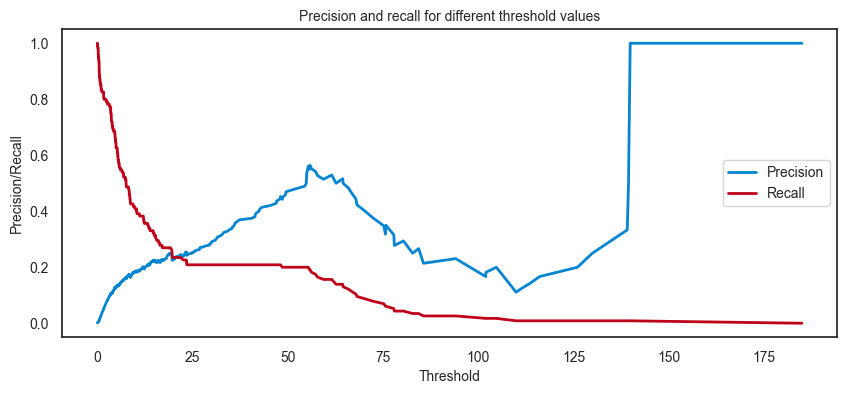

In [60]:
plt.figure(figsize=(10, 4))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:]   , label="Recall"   ,linewidth=2)

plt.title('Precision and recall for different threshold values', fontsize=10)
plt.xlabel('Threshold', fontsize=10)
plt.ylabel('Precision/Recall', fontsize=10)
plt.tick_params(axis='both', labelsize=10)
plt.legend(fontsize=10)

plt.show()

In [28]:
# Compute F1 score for each threshold (excluding the last threshold which doesn't have a corresponding value)
f1_scores = 2 * precision_rt[:-1] * recall_rt[:-1] / (precision_rt[:-1] + recall_rt[:-1] + 1e-8)

# Find the index of the maximum F1 score
best_index = np.argmax(f1_scores)

# Get the optimal threshold value
optimal_threshold_f1 = threshold_rt[best_index]

# Print results
print(f"Optimal threshold based on F1 score: {optimal_threshold_f1:.4f}")
print(f"F1 Score at optimal threshold: {f1_scores[best_index]:.4f}")
print(f"Precision: {precision_rt[best_index]:.4f}")
print(f"Recall: {recall_rt[best_index]:.4f}")

Optimal threshold based on F1 score: 55.7040
F1 Score at optimal threshold: 0.2949
Precision: 0.5610
Recall: 0.2000


**Reconstruction Error vs Threshold Check**

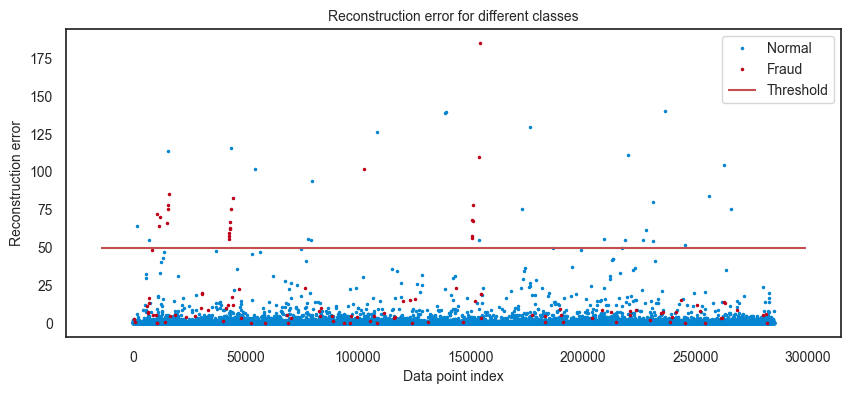

In [29]:
threshold_fixed = 50
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(10, 4))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=1.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
# Set tick font size
ax.tick_params(axis='both', labelsize=10)
ax.legend(fontsize=10)
plt.title("Reconstruction error for different classes", fontsize=10)
plt.ylabel("Reconstruction error", fontsize=10)
plt.xlabel("Data point index", fontsize=10)
plt.show();

## Conclusions

The results show that **autoencoders can be used for detecting fraud**, even in highly imbalanced datasets like credit card transactions.  
Specifically:

- **High AUC (Area Under the ROC Curve)**:  
  The reported AUC is close to **0.93**, indicating that the autoencoder can **strongly separate** fraudulent transactions from normal ones based only on reconstruction error. But this is probably an to much optimistic view.

- **Good Precision and Recall trade-off**:  
  Despite the severe class imbalance (fraud cases being extremely rare), the autoencoder maintained **reasonable recall** (detecting a good proportion of frauds) without sacrificing too much precision (keeping false alarms relatively low).

- **Threshold tuning is critical**:  
  The choice of the reconstruction error threshold directly impacts performance. Proper tuning is necessary to balance **false positives** (normal transactions incorrectly flagged) and **false negatives** (fraud cases missed).

- **Anomaly detection capability**:  
  Since the autoencoder was trained only on normal transactions, it naturally **models the "normal behavior"**, making it particularly suited for **unsupervised** or **semi-supervised** fraud detection, where fraud examples are rare or even unknown during training.

- **Limitations**:  
  While promising, autoencoders are **not perfect**. There is still a trade-off between catching more frauds and avoiding false positives. Moreover, they may struggle if fraudulent transactions closely mimic normal ones (i.e., are not true "outliers").

## Reference and Credits

D. Surana, "***Fraud detection using Autoencoders in Keras***", [Kaggle.com](https://www.kaggle.com/code/deepaksurana/fraud-detection-using-autoencoders-in-keras/notebook)